<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is avaliable')

cuda:0 is avaliable


In [ ]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    batch_size=x.shape[0]
    return x.view(batch_size, -1)

class Deflatten(nn.Module):
  def __init__(self,k):
    super(Deflatten, self).__init__()
    self.k = k
  
  def forward(self, x):
    s = x.size()

    feature_size = int((s[1]//self.k)**.5)

    return x.view(s[0], self.k, feature_size, feature_size)

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    k = 16
    # 인코더 부분
    # padding이 없음으로 크기가 줄어듬
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(k, 2*k, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(1024,10),
        nn.ReLU()
    )

    # 디코더 부분
    # 이미지 사이즈를 늘리기 위해 ConvTranspose를 사용하여 늘림(업셈플링시 사용)
    self.decoder = nn.Sequential(
        nn.Linear(10,1024),
        nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(2*k, k, 3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
     encoded = self.encoder(x)
     decoded = self.decoder(encoded)

     return decoded

In [ ]:
model = Autoencoder().to(device)

In [ ]:
def normalize_output(img):
  img = (img-img.min())/(img.max()-img.min())
  return img

def check_plot():
  with torch.no_grad():
    for data in trainloader:
      inputs = data[0].to(device)
      outputs = model(inputs)

      input_samples = inputs.permute(0,2,3,1).cpu().numpy()
      reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy()
      break

  columns = 10
  rows=5

  fig = plt.figure(figsize=(columns, rows))

  for i in range(1, columns*rows+1):
    img=input_samples[i-1]
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img.2)
    plt.axis('off')
  plt.show()

  fig = plt.figure(figsize=(columns, rows))

  for i in range(1, columns*rows+1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
  plt.show()


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

[1] loss: 0.089467


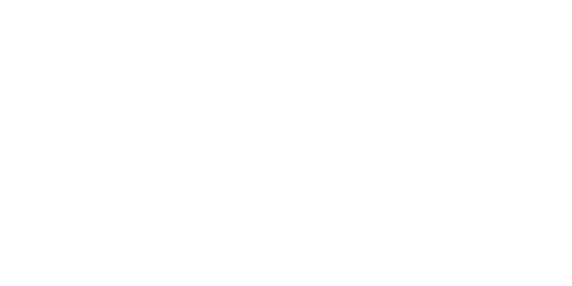

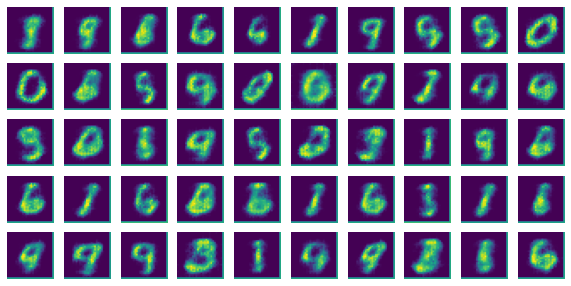

[11] loss: 0.030875


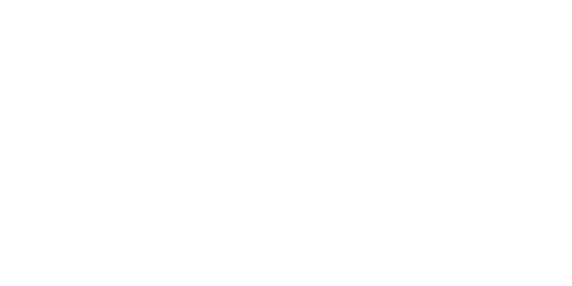

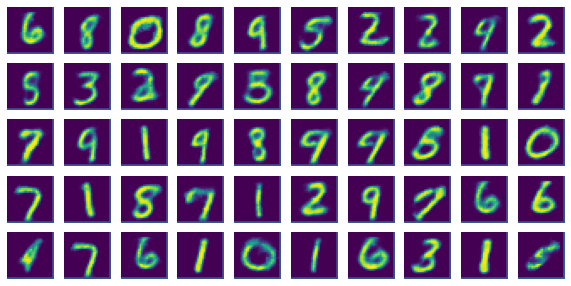

[21] loss: 0.023716


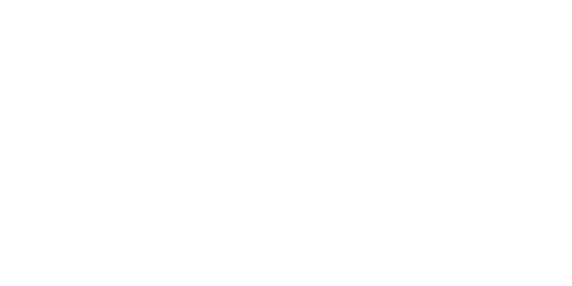

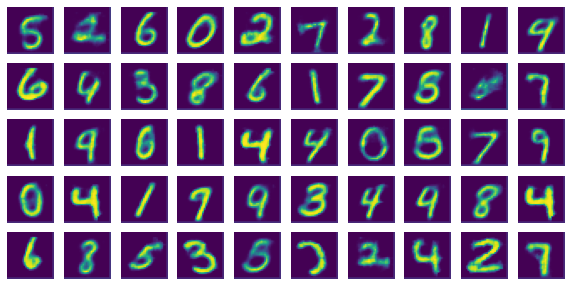

[31] loss: 0.020377


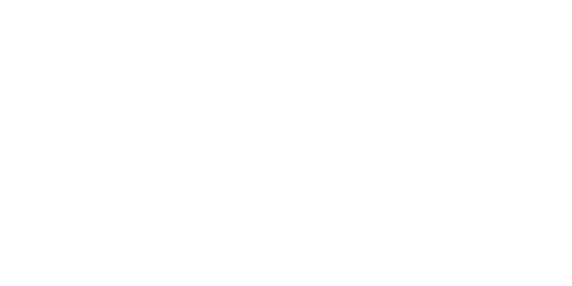

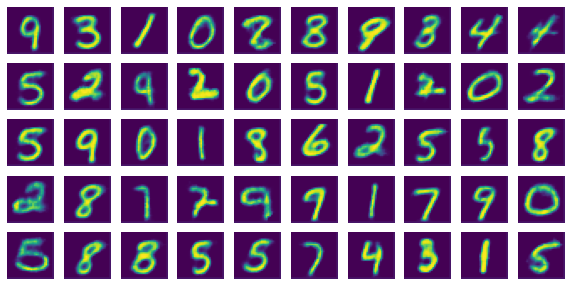

[41] loss: 0.018935


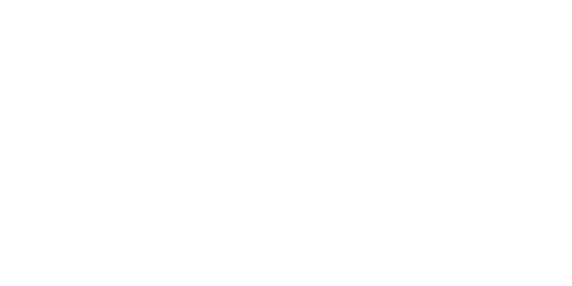

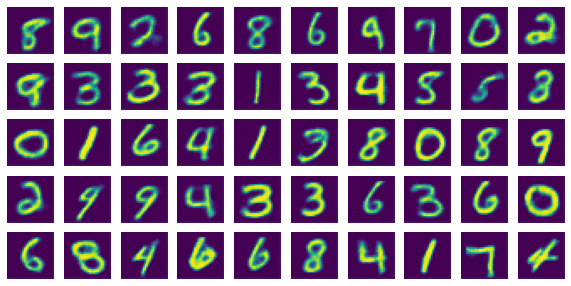

[51] loss: 0.018153


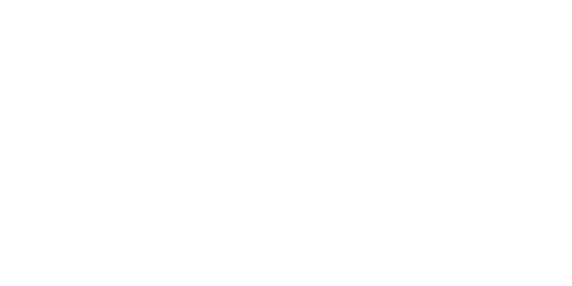

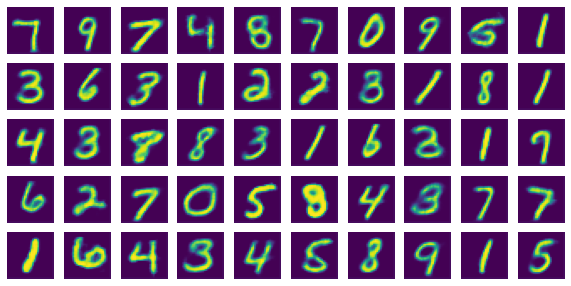

In [ ]:
for epoch in range(51):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs = data[0].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(inputs, outputs)

    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  cost = running_loss / len(trainloader)

  if epoch%10 == 0:
    print('[%d] loss: %3f' % (epoch+1, cost))
    check_plot()